# Gift Recommender Engine: Creating a Topic Classifier

## Import Libraries

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import spacy
import pickle
import warnings
warnings.filterwarnings('ignore')

In [152]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, plot_confusion_matrix

In [2]:
data = pd.read_csv('datasets/train-test-data4.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.dropna(inplace=True)

In [3]:
data.head()

,category,clean-text
0,Electronics/Gadgets,new tech discord server unfortunately due extr...
1,Electronics/Gadgets,intel chief warn two year chip shortage
2,Electronics/Gadgets,new york state fight dismissal antitrust lawsu...
3,Electronics/Gadgets,microsoft profit skyrocket percent
4,Electronics/Gadgets,hide malware inside ai neural network


## Import Functions to Clean User Input

In [9]:
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

In [22]:
punctuations = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = text.split() #split into list
    #text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    text = [s.lower() for s in text] #convert every character into lowercase
    text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    return text

## Modelling

### Splitting Training and Testing Data

In [84]:
X = data['clean-text']
y = data['category']

le = LabelEncoder()
y = le.fit_transform(y)

In [85]:
ref = dict(zip(data['category'].to_numpy(), y))
ref = {k:v for k,v in sorted(ref.items(), key=lambda item: item[1])}

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=8)

### Vectorize Words Using TF-IDF

In [87]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test_t = tfidf.transform(X_test)

### Model 1: Multinomial Naive Bayes - Training and Evaluation

In [52]:
# Training a Multinomial Naive Bayes Model
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test_t)

In [53]:
print('Naive Bayes Model Accuracy: {}%'.format(round(nb.score(X_test_t, y_test) * 100)))

Naive Bayes Model Accuracy: 79%


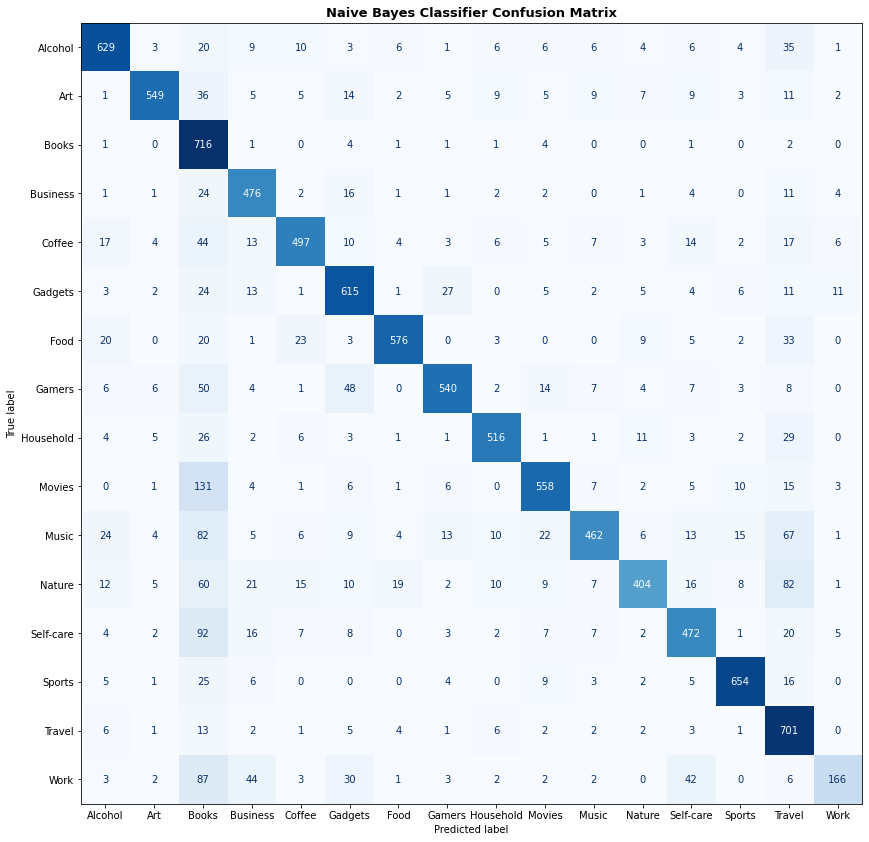

In [54]:
fig, ax = plt.subplots(figsize=(14,16))
labels = [k for k, v in ref.items()]
labels = np.char.replace(labels, 'Electronics/Gadgets', 'Gadgets')
plot_confusion_matrix(nb, X_test_t, y_test,cmap=plt.cm.Blues, ax=ax, colorbar=False, display_labels=labels)
ax.set_title('Naive Bayes Classifier Confusion Matrix', fontweight='bold', fontsize=13)
plt.show()

### Model 2: One vs. Rest Classifier Strategy, LinearSVC - Training and Evaluation (Best Model!)

In [88]:
ovr_svc = OneVsRestClassifier(LinearSVC(random_state=0))
ovr_svc.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(random_state=0))

In [89]:
y_pred = ovr_svc.predict(X_test_t)
y_score = ovr_svc.fit(X_train, y_train).decision_function(X_test_t)

In [90]:
print('Support Vector Model Accuracy: {}%'.format(round(ovr_svc.score(X_test_t, y_test) * 100)))

Support Vector Model Accuracy: 85%


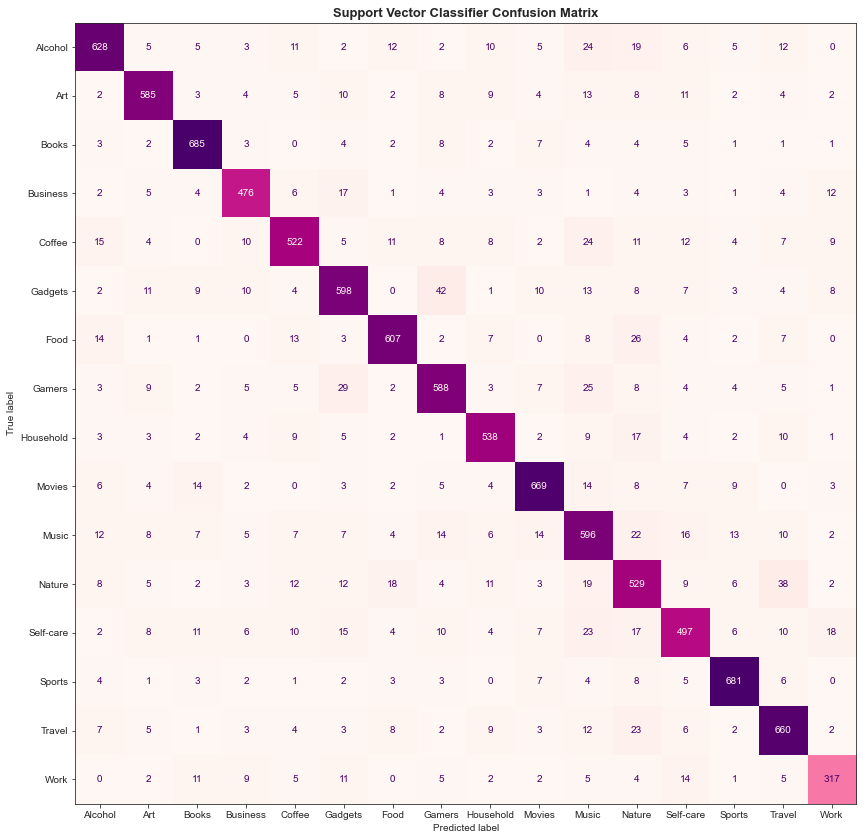

In [92]:
fig, ax = plt.subplots(figsize=(14,16))
labels = [k for k, v in ref.items()]
labels = np.char.replace(labels, 'Electronics/Gadgets', 'Gadgets')
sns.set_style('ticks')
plot_confusion_matrix(ovr_svc, X_test_t, y_test, ax=ax, colorbar=False, cmap = 'RdPu', display_labels=labels)
ax.set_title('Support Vector Classifier Confusion Matrix', fontweight='bold', fontsize=13)
fig.savefig('figures/confusion_matrix')
plt.show()

#### ROC AUC Plot

In [69]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

X = data['clean-text']
y = data['category']

# Binarize the output
y = label_binarize(y, classes=list(data['category'].value_counts().index))
n_classes = y.shape[1]

random_state = np.random.RandomState(0)
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25,
                                                    random_state=0)
classifier = OneVsRestClassifier(LinearSVC(random_state=random_state))
tfid_vectorizer = TfidfVectorizer(stop_words='english')
tf_OvR_train = tfid_vectorizer.fit_transform(X_train)
y_score = classifier.fit(tf_OvR_train, y_train).decision_function(tfid_vectorizer.transform(X_test))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


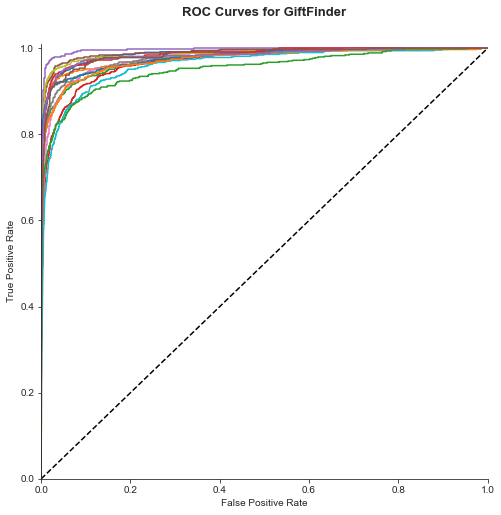

In [77]:
from scipy import interp

plt.figure(figsize=(8, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for GiftFinder', fontsize=13, fontweight='bold', y=1.05)
#plt.legend(loc="lower right")
sns.despine()
plt.show()

### Model 3: Ensemble Model Composed of Naive Bayes and Support Vector Classifier

In [23]:
def ensemble(nb, svc, tfidf, text):
    
    text = preprocess(text)
    text = tfidf.transform([text])
    
    nb_topic = nb.predict(text)
    nb_prob = nb.predict_proba(text)[0]
    
    svc_topic = svc.predict(text)
    p = np.array(svc.decision_function(text))
    svc_prob = max(np.exp(p)/np.sum(np.exp(p),axis=1, keepdims=True)[0])

    if (0.8 * max(nb_prob)) > max(svc_prob):
        return nb_topic
    else:
        return svc_topic

In [24]:
result = X_test.apply(lambda x: ensemble(nb, ovr_svc, tfidf, x)[0])
outcome = pd.DataFrame({'predicted': result, 'actual': y_test})
outcome['is-same'] = outcome['predicted'] == outcome['actual']

In [25]:
same_counts = outcome['is-same'].value_counts()[1]
diff_counts = outcome['is-same'].value_counts()[0]

print('Ensemble Score: ', same_counts/(same_counts + diff_counts))

Ensemble Score:  0.8297161936560935


### Model 4: Stochastic Gradient Descent

In [15]:
sgd = OneVsRestClassifier(SGDClassifier(random_state=0))
sgd.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(random_state=0))

In [17]:
print('SGD Model Accuracy: {}%'.format(round(sgd.score(X_test_t, y_test) * 100)))

SGD Model Accuracy: 84%


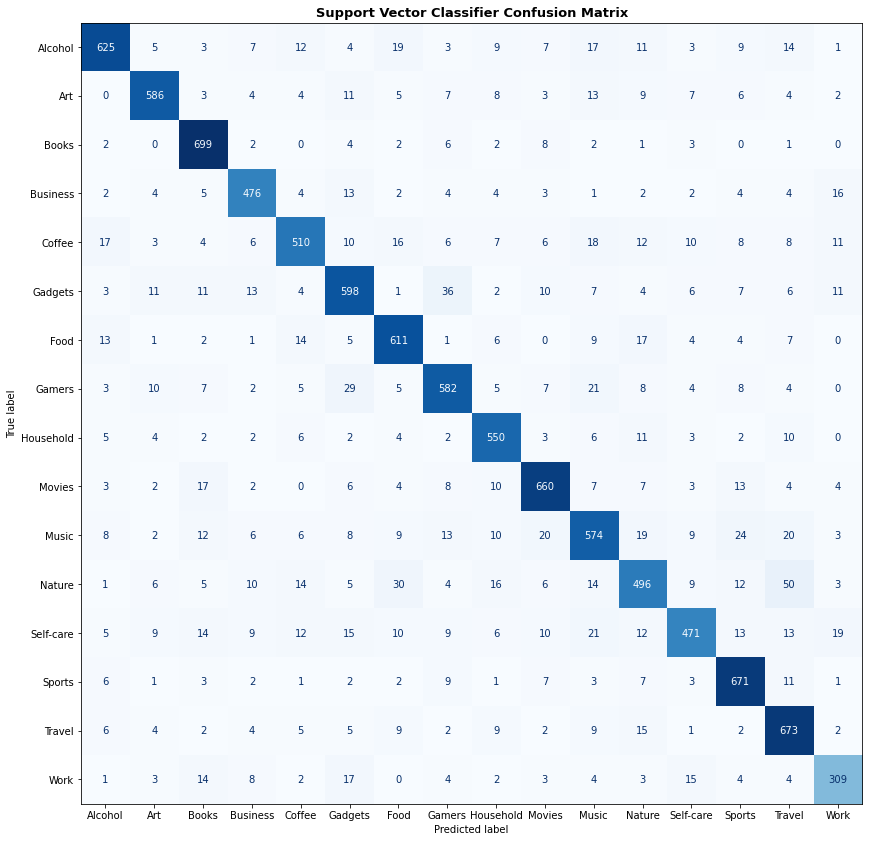

In [18]:
fig, ax = plt.subplots(figsize=(14,16))
labels = [k for k, v in ref.items()]
labels = np.char.replace(labels, 'Electronics/Gadgets', 'Gadgets')
plot_confusion_matrix(sgd, X_test_t, y_test,cmap=plt.cm.Blues, ax=ax, colorbar=False, display_labels=labels)
ax.set_title('Support Vector Classifier Confusion Matrix', fontweight='bold', fontsize=13)
plt.show()

### Model 5: Hyperparameter Tuning, OvR Support Vector Classifier

In [160]:
tuned_parameters = [{'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 'estimator__penalty': ['l1', 'l2']}]
ovr_svc = OneVsRestClassifier(LinearSVC(random_state=0))
clf = GridSearchCV(ovr_svc, tuned_parameters, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=LinearSVC(random_state=0)),
             param_grid=[{'estimator__C': [100, 10, 1, 0.1, 0.01, 0.001,
                                           0.0001],
                          'estimator__penalty': ['l1', 'l2']}])

In [163]:
clf.best_estimator_

OneVsRestClassifier(estimator=LinearSVC(C=1, random_state=0))

### Save Models to Pickle

In [21]:
#filename = open('models/nb_baseline2.sav', 'wb')
#pickle.dump(nb, filename)

In [22]:
#filename = open('models/linear_svc_baseline2.sav', 'wb')
#pickle.dump(ovr_svc, filename)

In [23]:
#filename = open('models/tfidf_vectorizer2.sav', 'wb')
#pickle.dump(tfidf, filename)

## Model Evaluation

### Sanity Check: Made Up Tweets!

In [67]:
key = {v:k for k, v in ref.items()}

In [61]:
filename = open('models/reference-dict.pickle', 'wb')
pickle.dump(key, filename)

In [62]:
nb_correct = ["My phone is broken, I really need a new one!", "I'm so tired at work, I really need to relax!", 
              "I'm so tired, I really need a vacation!", "I want to go on a holiday", "I love pandas", 
             "Went to the MET and saw Van Gogh portraits"]

svc_correct = ["Just went to the Grammys! Loved it"]

In [147]:
tweet = nb_correct[2]
tweet = preprocess(tweet)
tweet = ' '.join(spacy_lemmatize(tweet))

In [148]:
tweet = tfidf_model.transform([tweet])

In [149]:
print('Support Vector Topic Prediction:', key[ovr_svc.predict(tweet)[0]])
print('Naive Bayes Topic Prediction:', key[nb.predict(tweet)[0]])

Support Vector Topic Prediction: Work
Naive Bayes Topic Prediction: Travel


### Testing on Previously Unseen Subreddit Posts

In [164]:
# Import Models
import pickle

# Naive Bayes Model
filename = open('models/nb_baseline2.sav', 'rb')
nb = pickle.load(filename)

# Support Vector Classifier Model
filename = open('models/linear_svc_baseline2.sav', 'rb')
ovr_svc = pickle.load(filename)

# Import Vectorizer
filename = open('models/tfidf_vectorizer2.sav', 'rb')
tfidf_model = pickle.load(filename)

#Import Reference Dictionary
filename = open('models/reference-dict.pickle', 'rb')
ref = pickle.load(filename)

In [165]:
test_df = pd.read_csv('datasets/reddit-test-data.csv')
test_df.drop('Unnamed: 0', axis=1, inplace=True)
test_df.fillna('', inplace=True)

test_df['all-text'] = test_df['title'] + ' ' + test_df['body']
test_df['clean'] = test_df['all-text'].map(preprocess)

X = test_df['clean']
y = test_df['category']

#key = {v: k for k, v in ref.items()}
y = y.map(ref)

In [168]:
#ensemble_predict = X.apply(lambda x: ensemble(nb, ovr_svc, tfidf, x)[0])

In [169]:
#ensemble_result = pd.DataFrame({'predict': ensemble_predict, 'real': y})
#ensemble_result['is-same'] = ensemble_result['predict'] == ensemble_result['real']
#same_counts = ensemble_result['is-same'].value_counts()[1]
#diff_counts = ensemble_result['is-same'].value_counts()[0]

In [256]:
print('Ensemble Score on New Subrreddit: ', same_counts/(same_counts+diff_counts))

Ensemble Score on New Subrreddit:  0.63


In [26]:
X = tfidf.transform(X)
print('Naive Bayes Score on New Subreddit: ', nb.score(X, y))
print('Support Vector Classifier Score: ', ovr_svc.score(X, y))

### Word Analysis

In [37]:
topic_list = [v for k, v in ref.items()]

In [39]:
topic_docs = []
for cat in topic_list:
    a = ' '.join([text for text in data[data['category']==cat]['clean-text']])
    topic_docs.append(a)

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(topic_docs)    

mat_array = tfidf_matrix.toarray()

In [40]:
fn = tfidf.get_feature_names()

In [41]:
from collections import defaultdict

i = 0
important_words = defaultdict(dict)
for l in mat_array:
    name = topic_list[i]
    words = [(fn[x].encode('utf-8'),round(l[x],3)) for x in (l*-1).argsort()][:10]
    print(u"{}\n{}\n".format(name, words))
    important_words[name] = words
    i += 1

Alcohol
[(b'vodka', 0.405), (b'tequila', 0.334), (b'beer', 0.291), (b'drink', 0.277), (b'like', 0.227), (b'bottle', 0.223), (b'wine', 0.184), (b'good', 0.162), (b'liquor', 0.154), (b'try', 0.147)]

Art
[(b'lens', 0.288), (b'mm', 0.253), (b'use', 0.243), (b'look', 0.191), (b'like', 0.16), (b'camera', 0.155), (b'box', 0.155), (b'good', 0.132), (b'work', 0.131), (b'sony', 0.13)]

Books
[(b'book', 0.495), (b'read', 0.264), (b'chapter', 0.201), (b'like', 0.199), (b'want', 0.159), (b'story', 0.135), (b'know', 0.13), (b'write', 0.129), (b'audiobook', 0.124), (b'time', 0.121)]

Business
[(b'bitcoin', 0.332), (b'crypto', 0.204), (b'like', 0.177), (b'btc', 0.175), (b'year', 0.174), (b'make', 0.17), (b'use', 0.148), (b'time', 0.144), (b'know', 0.132), (b'pay', 0.129)]

Coffee
[(b'coffee', 0.629), (b'barista', 0.198), (b'use', 0.172), (b'grinder', 0.171), (b'make', 0.168), (b'like', 0.165), (b'espresso', 0.162), (b'brew', 0.145), (b'work', 0.107), (b'good', 0.106)]

Electronics/Gadgets
[(b'use', 0